## 미들 웨어 
- 모든 단게에서 에이전트 실행을 제어하고 사용자를 정의
- 미들웨어는 에이전트 내부에서 발생하는 일을 보다 엄격하게 제어 하는 방법을 제공
- 핵심 에이전트 루프는 모델을 호출 -> 실행할 도구 선택 -> 더 이상 도구 호출 안하면 종료하는 과정 포함.
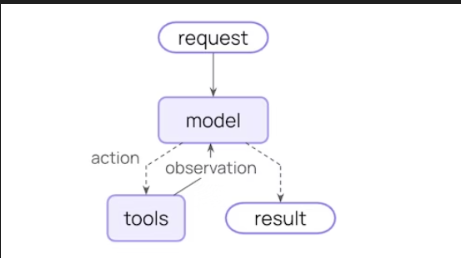
- 미들웨어는 각 단계의 전과 후에 후크를 노출함.
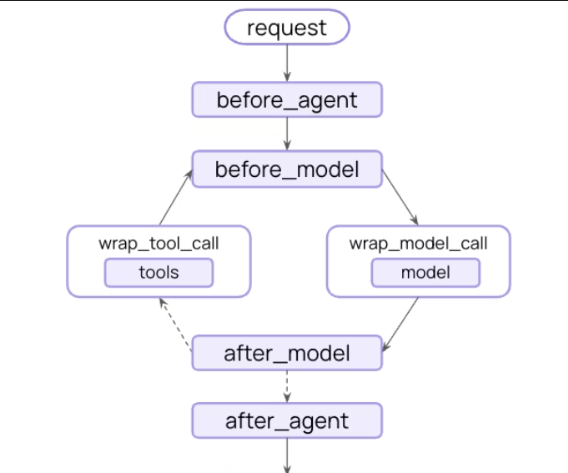

## 미들웨어는 무엇을 할수 있나?
- Monitor
    - 로깅, 분석 및 디버깅을 통해 에이전트 동작을 추적
- Modify
    - 변환 프롬프트, 도구 선택 및 출력 형식
- Control
    - 재시도, 폴백 및 조기 종료 논리 추가
- Enforce
    - 속도 제한, 가드레일 및 PII 감지 적용

In [ ]:
# 미들웨어 추가 방법

from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware, HumanInTheLoopMiddleware


agent = create_agent(
    model="gpt-4o",
    tools=[...],
    middleware=[SummarizationMiddleware(), HumanInTheLoopMiddleware()],
)

## 내장 미들웨어 (Built-in middleware:Summarization)
- Summarization(요약)
- 역할 : 컨텍스트 토큰 한계에 가까워질 때, **대화 히스토리**를 자동으로 요약
    - 장기 대화: 컨텍스트 윈도우를 초과하는 오래가는 대화
    - 멀티턴 대화: 히스토리가 방대해지는 다회전(Dialogue)
    - 문맥 보존이 중요한 앱: 전체 문맥을 최대한 유지해야 하는 애플리케이션

## 설정 옵션 (한글 설명)

- model (string, 필수)
요약을 생성할 때 사용할 모델 이름.

권장: 본문 응답 모델보다 경량 모델(예: gpt-4o-mini)을 써서 비용/지연 줄이기

- max_tokens_before_summary (number)
요약을 트리거하는 토큰 임계치. 이 한계에 가까워지면 요약 수행.

- messages_to_keep (number, 기본값: "20")
요약 이후에도 그대로 남겨둘 최신 메시지 수.

최신 맥락은 원문 유지 → 답변 품질 ↑

- token_counter (function)
커스텀 토큰 카운터 함수. 기본은 문자 기반 대략치.

정확한 제어가 필요하면 tiktoken 등으로 직접 토큰 세기 함수 주입

- summary_prompt (string)
요약 프롬프트 템플릿. 지정하지 않으면 기본 템플릿 사용.

도메인 특화 요약(예: “결정/To-Do/제약사항” 강조) 시 커스텀 권장

- summary_prefix (string, 기본값: "## Previous conversation summary:")
요약 메시지 앞에 붙는 접두어.

프롬프트 상에서 요약 영역을 모델/사람 모두가 한눈에 구분 가능

In [ ]:
from langchain.agents import create_agent
# 무엇: LLM + (툴 호출 루프)로 동작하는 에이전트를 만들어주는 팩토리.
# 흐름: 메시지 → LLM 호출 → tool_calls 있으면 툴 실행 → 결과를 메시지에 합치고 반복.

from langchain.agents.middleware import SummarizationMiddleware
# 무엇: 내장 미들웨어. 대화가 길어질 때 히스토리를 자동 요약해 컨텍스트 창 초과/비용 폭증을 방지.


agent = create_agent(
    model="gpt-4o",                         # 무엇: 메인 응답용 LLM(답변 생성 담당).
                                            # 왜: 에이전트 루프에서 기본적으로 이 모델로 응답을 생성.

    tools=[weather_tool, calculator_tool],  # 무엇: LLM이 필요 시 호출하는 함수(@tool 래핑).
                                            # 흐름: 모델 응답에 tool_calls가 있으면 해당 툴 실행 → ToolMessage로 합쳐서 다음 턴으로.

    middleware=[
        SummarizationMiddleware(
            model="gpt-4o-mini",            # 무엇: '요약 전용' 모델(경량 추천).
                                            # 왜: 요약은 빈번하게 발생 → 경량 모델이면 비용/지연을 절약.

            max_tokens_before_summary=4000, # 무엇: 토큰이 이 임계치를 넘기기 전에 요약을 트리거.
                                            # 왜: 컨텍스트 창 초과로 잘리지 않게 선제적으로 압축.
                                            # 팁: 실제 컨텍스트 한도의 50~70% 지점으로 잡으면 안전.

            messages_to_keep=20,            # 무엇: 요약 후에도 원문 그대로 남길 '최신 N개' 메시지.
                                            # 왜: 최근 맥락은 요약 없이 보존해야 답변 품질이 떨어지지 않음.
                                            # 흐름: "이전 대화 요약" + "최신 20개 원문" 조합으로 다음 턴 생성.

            summary_prompt="Custom prompt for summarization...",  # 선택: 요약 지시 프롬프트 커스텀.
                                            # 왜: 도메인별 핵심(결정사항/할 일/제약/수치)을 강조하려면 커스텀 프롬프트가 유리.
                                            # 미지정 시 기본 템플릿 사용.

            # 참고: 지정 가능하지만 생략된 옵션들
            # token_counter=...             # 커스텀 토큰 카운터 함수(기본은 대략적 문자 기반).
            # summary_prefix="## Previous conversation summary:"  # 요약 메시지 접두어(기본값).
        ),
    ],
)
